## Challange: Improve NLP Model
<br>
I am using <a href='https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge'>this Kaggle competition</a> to build an NLP model. This notebook covers my attempt to improve my model performance.<br>
This time around, I'm going to use a technique inspired by <a href='https://nlp.stanford.edu/pubs/sidaw12_simple_sentiment.pdf'>this paper</a> (<I>Baselines and Bigrams: Simple, Good Sentiment and Topic Classification</I> by Sida Wang and Christopher D. Manning) and implimented in <a href='https://www.kaggle.com/jhoward/nb-svm-strong-linear-baseline-eda-0-052-lb'>a walkthrough by this Kaggle contributor</a>.

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy
import nltk
import gc
import re, string
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import log_loss, make_scorer
from scipy import sparse
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from sklearn.linear_model import LogisticRegression
from IPython.display import Image


In [5]:
df = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
classes = [
    'toxic',
    'severe_toxic',
    'obscene', 
    'threat',
    'insult', 
    'identity_hate'
]

In [3]:
ll_scorer = make_scorer(log_loss, greater_is_better=False)

In [11]:
class NbSvmClassifier(BaseEstimator, ClassifierMixin):
    """This is the paper-inspired NB-prior assisted model. The contributor uses
    logistic regression instead of SVM for computation time. Another contributor
    created this sklearn-like implimentation.
    """
    def __init__(self, C=1.0, dual=False, n_jobs=1):
        self.C = C
        self.dual = dual
        self.n_jobs = n_jobs

    def predict(self, x):
        # Verify that model has been fit
        check_is_fitted(self, ['_x', '_y', '_r', '_clf'])
        return self._clf.predict(x.multiply(self._r))

    def predict_proba(self, x):
        # Verify that model has been fit
        check_is_fitted(self, ['_x', '_y', '_r', '_clf'])
        return self._clf.predict_proba(x.multiply(self._r))

    def fit(self, x, y):
        # Check that X and y have correct shape
        y = y.values
        x, y = check_X_y(x, y, accept_sparse=True)

        # Store labels, X and y
        self._x = x
        self._y = y
        self._classes = unique_labels(y)

        def pr(x, y_i, y):
            p = x[y==y_i].sum(0)
            return (p+1) / ((y==y_i).sum()+1)
        self._r = np.log(pr(x,1,y) / pr(x,0,y))
        self._clf = LogisticRegression(C=self.C, dual=self.dual, n_jobs=self.n_jobs)
        x_nb = x.multiply(self._r)
        self._clf.fit(x_nb, y)
        return self
    
class NullModel(object):
    """This is our benchmark model, which return the same prediction for each document
    (not toxic)
    """
    def __init__(self):
        return None
    
    def fit(self, Xtrain, Ytrain):
        return self
    
    def predict(self, X):
        length = X.shape[0]
        return [0 for x in range(0, length)]
    
    def get_params(self, deep=False):
        return {}

In [8]:
test.comment_text.isnull().any()

True

In [10]:
test.comment_text = np.where(test.comment_text.isnull(), '', test.comment_text)

In [13]:
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()

In [17]:
tokenize(df.iloc[5].comment_text)

['Fried', 'chickens', 'Is', 'dat', 'sum', 'fried', 'chickens', '?']

In [18]:
def test_features(df, X):
    """This function runs a simple naive bayes model on the extracted features
    and compares its performance to the null model for each class.
    Returns a dataframe object with results.
    """
    mean_ll = []
    null_ll = []
    mean_acc = []
    maj_class = []
    for cls in classes:
        print('working on', cls)
        Y = df[cls]
        mod = NbSvmClassifier(C=4, dual=True, n_jobs=1)
        mean_ll.append(cross_val_score(mod, X, Y, scoring=ll_scorer, cv=5).mean())
        nulmod = NullModel()
        null_ll.append(cross_val_score(nulmod, X, Y, scoring=ll_scorer).mean())
        mean_acc.append(cross_val_score(mod, X, Y, cv=5).mean())
        maj_class.append(1-(Y.sum()/len(df)))

    result = pd.DataFrame()
    result['class'] = classes
    result['mean_log_loss'] = mean_ll
    result['null_log_loss'] = null_ll
    result['mean_accuracy'] = mean_acc
    result['majority_class_prior'] = maj_class
    return result

In [19]:
gc.collect()
vctr = TfidfVectorizer(
    ngram_range=(1,2), 
    tokenizer=tokenize,
    min_df=3, 
    max_df=0.9, 
    strip_accents='unicode', 
    use_idf=1,
    smooth_idf=1, 
    sublinear_tf=1 
)

print('vectorizing!')
X = vctr.fit_transform(df.comment_text)
print('modeling!')
result = test_features(df, X)
print(result)
print(result.mean_log_loss.mean())

vectorizing!
modeling!
           class  mean_log_loss  null_log_loss  mean_accuracy  \
0          toxic      -1.315598      -3.328444       0.961910   
1   severe_toxic      -0.331513      -0.347727       0.990402   
2        obscene      -0.735814      -1.840968       0.978696   
3         threat      -0.099454      -0.109903       0.997121   
4         insult      -1.006430      -1.717012       0.970861   
5  identity_hate      -0.262687      -0.293315       0.992394   

   majority_class_prior  
0              0.903632  
1              0.989932  
2              0.946699  
3              0.996818  
4              0.950287  
5              0.991508  
-0.625249287861


In [20]:
print(result.mean_log_loss.mean())
print(result.null_log_loss.mean())

-0.625249287861
-1.27289486639


In [23]:
gc.collect()
sub = pd.DataFrame(index=test.index, columns=['id'] + classes)
sub['id'] = test['id']
print('vectorizing!')
X_test = vctr.transform(test.comment_text)
for cls in classes:
    print('predicting', cls)
    print('fitting...')
    mod = NbSvmClassifier(C=4, dual=True, n_jobs=1)
    mod.fit(X, df[cls])
    print('predicting...')
    sub[cls] = mod.predict_proba(X_test)[:,1]

vectorizing!
predicting toxic
fitting...
predicting...
predicting severe_toxic
fitting...
predicting...
predicting obscene
fitting...
predicting...
predicting threat
fitting...
predicting...
predicting insult
fitting...
predicting...
predicting identity_hate
fitting...
predicting...


In [29]:
sub.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,6044863,0.005677,0.000518,0.002279,0.000129,0.002221,0.000532
1,6102620,0.003165,0.000214,0.002768,0.000107,0.001442,0.000403
2,14563293,0.001239,0.000355,0.001457,0.000117,0.001352,0.000239
3,21086297,0.018860,0.001049,0.005513,0.000156,0.004371,0.000299
4,22982444,0.004627,0.000809,0.002852,0.000140,0.001541,0.000647


In [28]:
sub.to_csv('attempt1.csv', index=False)

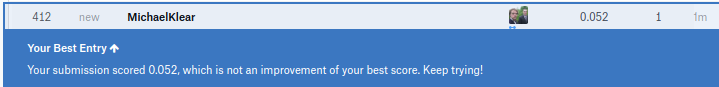

In [33]:
Image("scrnsht.png")